In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
from scipy.signal import fftconvolve
from scipy.special import expit

import electrode2currentmap as e2cm
import effectivecurrent2brightness as ec2b
import utils

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# use original TimeSeries implementation
class TimeSeriesSlow(utils.TimeSeries):
    def __init__(self, tsample, data, sleep_ms=0):
        """
        Represent a time-series.
        
        Reference (slow) implementation, obtained 9/7/2016 from pulse2percept master branch.
        """
        self.data = data
        self.tsample = tsample
        self.duration = self.data.shape[-1] * tsample
        self.shape = data.shape
        self.sampling_rate = 1 / tsample
        
        # The following is unnecessary, because it is unused.
        # Even worse, it's also a huge memory hog and makes the constructor slow.
        # Because a new TimeSeries object is created at every stage of the model cascade
        # for every cascade, its impact on speed/memory usage is significant...
        # Running simulations with > 0.5s stimulus duration failed on my machine with 32GB
        # RAM, as memory usage would continue to increase until no more memory could be
        # allocated.
        # Removing the next line gets rid of this issue.
        self.time = np.linspace(tsample, self.duration, data.shape[-1])
        
        # We want to see the impact on speed, but delete the variable right away so we
        # don't run out of memory.
        del self.time

In [4]:
class TemporalModelSlow(object):
    def __init__(self, tau1=.42/1000, tau2=45.25/1000,
                 tau3=26.25/1000, e=8.73, beta=.6, asymptote=14, slope=3,
                 shift=16):
        """
        A model of temporal integration from retina pixels.
        
        Reference (slow) implementation, obtained 9/7/2016 from pulse2percept master branch.
        Suggestions for how to speed up the code can be found in the comments below.
        """
        self.tau1 = tau1
        self.tau2 = tau2
        self.tau3 = tau3
        self.e = e
        self.beta = beta
        self.asymptote = asymptote
        self.slope = slope
        self.shift = shift

    def fast_response(self, stimulus, dojit=True):
        # slow: pre-calculate gamma once
        t = np.arange(0, 20 * self.tau1, stimulus.tsample)
        g = e2cm.gamma(1, self.tau1, t)
        
        # Don't calculate the 'full' discrete convolution, use mode 'same'
        # instead
        R1 = stimulus.tsample * utils.sparseconv(g, stimulus.data, dojit=dojit)

        # Converting to TimeSeries is slow, mainly due to np.linspace call in
        # the constructor. This is unnecessary overhead that happens at every
        # electrode / every stage of the cascade.
        return TimeSeriesSlow(stimulus.tsample, R1)

    def charge_accumulation(self, fast_response, stimulus):
        # same here, pre-calc gamma once
        t = np.arange(0, 8 * self.tau2, fast_response.tsample)
        g = e2cm.gamma(1, self.tau2, t)

        # calculated accumulated charge
        # np.maximum(0,x) seems to be faster than np.where
        rect_amp = np.where(stimulus.data > 0, stimulus.data, 0)  # rectify
        ca = stimulus.tsample * np.cumsum(rect_amp.astype(float), axis=-1)

        # Run fftconvolve in mode 'same'.
        # First argument is typically the data, second the kernel.
        chargeaccumulated = (self.e * stimulus.tsample *
                             fftconvolve(g, ca))

        # Don't do the zero padding yourself, run fftconvolve in mode 'same'
        # so it returns the correct dimensions.
        zero_pad = np.zeros(fast_response.shape[:-1] +
                            (chargeaccumulated.shape[-1] -
                             fast_response.shape[-1],))
        fast_response = TimeSeriesSlow(fast_response.tsample,
                                   np.concatenate([fast_response.data,
                                                   zero_pad], -1))

        R2 = fast_response.data - chargeaccumulated
        
        # np.maximum(0,x) seems to be faster than np.where
        R2 = np.where(R2 > 0, R2, 0)  # rectify again
        
        # converting to TimeSeries is slow
        return TimeSeriesSlow(fast_response.tsample, R2)

    def stationary_nonlinearity(self, fast_response_ca):
        # now we put in the stationary nonlinearity of Devyani's:
        R2norm = fast_response_ca.data / fast_response_ca.data.max()
        
        # Parentheses are misplaced w.r.t. Eq.3 in Nanduri et al. (2012).
        # Also, use scipy.signal.expit for a fast logistic function.
        scale_factor = (self.asymptote / (1 + np.exp(-(fast_response_ca.data /
                        self.slope) +
                        self.shift)))
        R3 = R2norm * scale_factor  # scaling factor varies with original
        
        # converting to TimeSeries is slow
        return TimeSeriesSlow(fast_response_ca.tsample, R3)

    def slow_response(self, fast_response_ca_snl):
        # same here, pre-calc gamma once
        t = np.arange(0, self.tau3 * 8, fast_response_ca_snl.tsample)
        g = e2cm.gamma(3, self.tau3, t)
        
        # Run fftconvolve in mode 'same'.
        # First argument is typically the data, second the kernel.
        c = fftconvolve(g, fast_response_ca_snl.data)
        
        # converting to TimeSeries is slow
        return TimeSeriesSlow(fast_response_ca_snl.tsample,
                          fast_response_ca_snl.tsample * c)

    def model_cascade(self, ecm, dojit):
        fr = self.fast_response(ecm, dojit=dojit)
        ca = self.charge_accumulation(fr, ecm)
        sn = self.stationary_nonlinearity(ca)
        return self.slow_response(sn)

In [5]:
def speedup(data, data_ref):
    """Calculate a speedup ratio.
    
    Returns a speedup ratio for a list of execution times `data` compared to
    reference data `data_ref`.
    """
    return np.mean(data_ref / data)

def percent_faster(data, data_ref):
    """Calculates % speed increase.
    
    Returns how much faster a list of execution times `data` is compared to
    reference data `data_ref` (percent).
    
    Aka: "`data` is on average X % faster than `data_ref`."
    """
    return np.mean((data_ref - data) / data_ref) * 100

In [6]:
# Create a Retina object that can hold the entire Argus I array (4x4 checkerboard, 880um center-to-center)
# width: 4 x 880um = 3520um, but add radii: 3520um + 130um + 260um = 3910 um, then add padding for current spread -> 5000um
r_sampling = 50  # spatial sampling of retina
r = e2cm.Retina(axon_map='../retina_argus_s' + str(r_sampling) + '.npz', 
                sampling=r_sampling, xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)

In [7]:
# Create Argus I electrode array 
# 4x4 checkerboard, 880um center-to-center, (almost) alternating electrode sizes

e_spacing = 880  # um
x_coord = np.arange(0, 4) * e_spacing - 1.5 * e_spacing
x_coord, y_coord = np.meshgrid(x_coord, x_coord, sparse=False)

# spatial arrangement of Argus I creates checkerboard with alternating electrode sizes
#   .  o  .  o
#   o  .  o  .
#   .  o  .  o
#   o  .  o  .
r_arr = np.array([260, 520, 260, 520])
r_arr = np.concatenate((r_arr, r_arr[::-1], r_arr, r_arr[::-1]), axis=0)
h_arr = np.ones(16)*0

e_all = e2cm.ElectrodeArray(r_arr.tolist(), x_coord.flatten().tolist(), y_coord.flatten().tolist(), h_arr.tolist())

In [8]:
# We derive the effective current stimulation (ecs; passed through the effect of the retinal layout, axons, etc.) 
# in addition to the current (cs):
ecs, cs  = r.electrode_ecs(e_all)

In [9]:
# for now, keep most params constant except for frequency and overall stimulus duration
tsample = .005/1000.
freq = 20
num_pts = 5
duration = np.linspace(0.1, 0.5, 5)

dojit = True

# resampling output
fps = 30
rs = int(1/(fps*tsample))

In [10]:
# The temporal model contains the cascade of operations that leads from pulse to percept.
# Here we are comparing two different versions:

# Reference implementation hard-copied from Sep 2016 master branch:
tm_slow = TemporalModelSlow()

# Sped up implementation / current standing:
tm = ec2b.TemporalModel(tsample=tsample)

In [11]:
# Warning: This might take a while... but see progress report prints

t_old = []  # list of execution times for the reference (slow) implementation
t_new = []  # list of execution times for the current implementation

for dur in duration:
    print('dur: %.2f' % dur)
    p2pt = e2cm.Psycho2Pulsetrain(freq, dur, pulse_dur=.075/1000, interphase_dur=.075/1000,
                                  tsample=tsample, current_amplitude=20,
                                  pulsetype='cathodicfirst')

    t0 = %timeit -n1 -r3 -oq ec2b.pulse2percept(tm_slow, ecs, r, [p2pt], rs, n_jobs=8, dojit=dojit, tol=0.01)
    print('  Done with t_old: %f' % t0.best)
    t_old.append(t0.best)

    t1 = %timeit -n1 -r3 -oq ec2b.pulse2percept(tm, ecs, r, [p2pt], rs, n_jobs=8, dojit=dojit, tol=0.01)
    print('  Done with t_new: %f' % t1.best)
    t_new.append(t1.best)
    
t_old = np.array(t_old)
t_new = np.array(t_new)

dur: 0.10
  Done with t_old: 55.977845
  Done with t_new: 25.892222
dur: 0.20
  Done with t_old: 66.003880
  Done with t_new: 34.538670
dur: 0.30
  Done with t_old: 79.643406
  Done with t_new: 44.573189
dur: 0.40
  Done with t_old: 91.792313
  Done with t_new: 55.515973
dur: 0.50
  Done with t_old: 105.336819
  Done with t_new: 65.756113


avg speedup 1.823x		avg 44.5% faster
avg speedup 1.823x		avg 44.5% faster


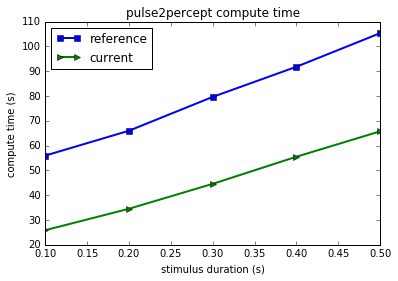

In [12]:
plt.plot(duration, t_old, '-s', linewidth=2, label='reference')
plt.plot(duration, t_new, '->', linewidth=2, label='current')
plt.xlabel('stimulus duration (s)')
plt.ylabel('compute time (s)')
plt.legend(loc='upper left')
plt.title('pulse2percept compute time')

print('avg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_new, t_old), 
                                                  percent_faster(t_new, t_old)))
print('avg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_new, t_old),
                                                  percent_faster(t_new, t_old)))

In [13]:
# memory usage in kb
utils.memory_usage()

{'peak': 1513364, 'rss': 351812}

In [14]:
# strong scaling
t_strong_old = []  # list of execution times for the reference (slow) implementation
t_strong_new = []  # list of execution times for the current implementation

dur = 0.5
num_jobs = np.arange(1, 9)

for n in num_jobs:
    print('n_jobs: %d' % n)
    p2pt = e2cm.Psycho2Pulsetrain(freq, dur, pulse_dur=.075/1000, interphase_dur=.075/1000,
                                  tsample=tsample, current_amplitude=20,
                                  pulsetype='cathodicfirst')

    t0 = %timeit -n1 -r3 -oq ec2b.pulse2percept(tm_slow, ecs, r, [p2pt], rs, n_jobs=n, dojit=dojit, tol=0.01)
    print('  Done with t_old: %f' % t0.best)
    t_strong_old.append(t0.best)

    t1 = %timeit -n1 -r3 -oq ec2b.pulse2percept(tm, ecs, r, [p2pt], rs, n_jobs=n, dojit=dojit, tol=0.01)
    print('  Done with t_new: %f' % t1.best)
    t_strong_new.append(t1.best)
    
t_strong_old = np.array(t_strong_old)
t_strong_new = np.array(t_strong_new)

n_jobs: 1
  Done with t_old: 433.675452
  Done with t_new: 235.306663
n_jobs: 2
  Done with t_old: 223.399945
  Done with t_new: 127.992463
n_jobs: 3
  Done with t_old: 154.811821
  Done with t_new: 88.889368
n_jobs: 4
  Done with t_old: 120.498037
  Done with t_new: 70.191663
n_jobs: 5
  Done with t_old: 117.962553
  Done with t_new: 70.786381
n_jobs: 6
  Done with t_old: 111.437243
  Done with t_new: 67.982823
n_jobs: 7
  Done with t_old: 106.875880
  Done with t_new: 66.577670
n_jobs: 8
  Done with t_old: 105.272378
  Done with t_new: 65.663470


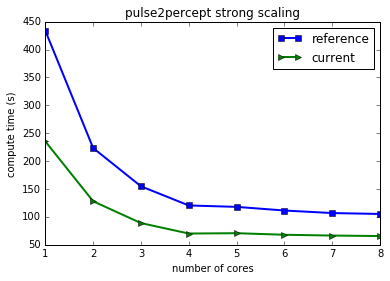

In [15]:
# Strong scaling: How compute time for a fixed problem size scales with the number of processors.
plt.plot(num_jobs, t_strong_old, '-s', linewidth=2, label='reference')
plt.plot(num_jobs, t_strong_new, '->', linewidth=2, label='current')
plt.xlabel('number of cores')
plt.ylabel('compute time (s)')
plt.legend(loc='upper right')
plt.title('pulse2percept strong scaling')

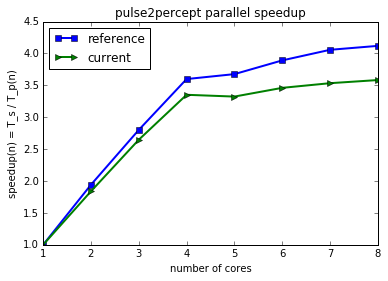

In [16]:
# Parallel speedup ratio: how much faster the parallel implementation is compared to serial
# speedup(num_jobs) = T_serial / T_parallel(num_jobs)
# https://wiki.scinet.utoronto.ca/wiki/index.php/Introduction_To_Performance#Parallel_Speedup
plt.plot(num_jobs, t_strong_old[0] / t_strong_old, '-s', linewidth=2, label='reference')
plt.plot(num_jobs, t_strong_new[0] / t_strong_new, '->', linewidth=2, label='current')
plt.xlabel('number of cores')
plt.ylabel('speedup(n) = T_s / T_p(n)')
plt.legend(loc='upper left')
plt.title('pulse2percept parallel speedup')

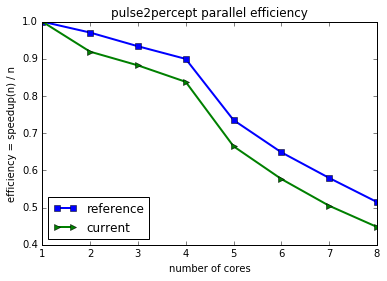

In [17]:
# Parallel efficiency is measured as speedup(num_jobs) / num_jobs.
# That is, if you get 8x speedup going from 1 to 8 processor, you're at 100% efficiency.
# https://wiki.scinet.utoronto.ca/wiki/index.php/Introduction_To_Performance#Efficiency
plt.plot(num_jobs, t_strong_old[0] / (num_jobs * t_strong_old), '-s', linewidth=2, label='reference')
plt.plot(num_jobs, t_strong_new[0] / (num_jobs * t_strong_new), '->', linewidth=2, label='current')
plt.xlabel('number of cores')
plt.ylabel('efficiency = speedup(n) / n')
plt.title('pulse2percept parallel efficiency')
plt.legend(loc='lower left')